# Pointwise R. - CONFIVE
## RF

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics.pairwise import euclidean_distances

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.neighbors import NearestNeighbors

In [2]:
# --- Metrics ---
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def smape(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

In [3]:
df = pd.read_csv("df_final_bh_amazonas.csv")
df_pollu = df.copy()
selected_cols_final = [
    'Date',
    'DayOfWeekNum',
    'WeekOfYear',
    'Month',
    'IsWeekend',
    'IsHoliday',
    'NUMBER_INT',
    'temp_max',
    'temp_min',
    'humidity_max',
]

df_final = df[selected_cols_final].copy()
df_final = df_final.dropna()

In [4]:
df_final['Date'] = pd.to_datetime(df_final['Date'])

# remove the last 5 days (account for lag ...)
df_final = df_final[:-5]

# Range for training and testing (4 years for training, 1 year for validation)
min_year = df_final['Date'].dt.year.min()
train_mask = df_final['Date'].dt.year < (min_year + 4)
val_mask = df_final['Date'].dt.year == (min_year + 4)


df_train = df_final[train_mask]
df_val = df_final[val_mask]


print(f"Training set size: {df_train.count()} rows")
print(f"Validation set size: {df_val.count()} rows")
print(f"Training set date range: {df_train['Date'].min()} to {df_train['Date'].max()}")
print(f"Validation set date range: {df_val['Date'].min()} to {df_val['Date'].max()}")

df_train = df_train.drop(columns=['Date'])
df_val = df_val.drop(columns=['Date'])

X = df_final.drop(columns=['Date', 'NUMBER_INT'])
y = df_final['NUMBER_INT']


X_train = df_train.drop(columns=['NUMBER_INT'])
y_train = df_train['NUMBER_INT']

X_val = df_val.drop(columns=['NUMBER_INT'])
y_val = df_val['NUMBER_INT']

Training set size: Date            1461
DayOfWeekNum    1461
WeekOfYear      1461
Month           1461
IsWeekend       1461
IsHoliday       1461
NUMBER_INT      1461
temp_max        1461
temp_min        1461
humidity_max    1461
dtype: int64 rows
Validation set size: Date            360
DayOfWeekNum    360
WeekOfYear      360
Month           360
IsWeekend       360
IsHoliday       360
NUMBER_INT      360
temp_max        360
temp_min        360
humidity_max    360
dtype: int64 rows
Training set date range: 2015-01-01 00:00:00 to 2018-12-31 00:00:00
Validation set date range: 2019-01-01 00:00:00 to 2019-12-26 00:00:00


In [5]:
X_train.head()

,DayOfWeekNum,WeekOfYear,Month,IsWeekend,IsHoliday,temp_max,temp_min,humidity_max
0,3,1,1,0,1,33.9,20.6,89.0
1,4,1,1,0,0,32.9,21.0,87.0
2,5,1,1,1,0,33.5,20.2,83.0
3,6,1,1,1,0,30.6,22.2,81.0
4,0,2,1,0,0,30.8,20.8,79.0


In [6]:
X_val.head()

,DayOfWeekNum,WeekOfYear,Month,IsWeekend,IsHoliday,temp_max,temp_min,humidity_max
1461,1,1,1,0,1,27.9,19.2,92.0
1462,2,1,1,0,0,31.1,18.9,90.0
1463,3,1,1,0,0,30.7,20.4,88.0
1464,4,1,1,0,0,25.4,19.0,91.0
1465,5,1,1,1,0,30.1,18.6,91.0


In [7]:
y_val.head()

1461    44
1462    45
1463    28
1464    37
1465    36
Name: NUMBER_INT, dtype: int64

In [8]:
results = []

In [9]:

best_rf_model_base = RandomForestRegressor(
    n_estimators=20,
    max_depth=6,
    min_samples_split=16,
    random_state=9
)

best_rf_model_base.fit(X_train, y_train)

y_pred = best_rf_model_base.predict(X_val)

# Metrics 1y
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val, y_pred)
mape_val = mape(y_val, y_pred)
smape_val = smape(y_val, y_pred)
r2 = r2_score(y_val, y_pred)
corr = np.corrcoef(y_val, y_pred)[0, 1]

results.append({
    'MSE': mse,
    'RMSE': rmse,
    'MAE': mae,
    'MAPE': mape_val,
    'sMAPE': smape_val,
    'R2': r2,
    'Correlation': corr
})

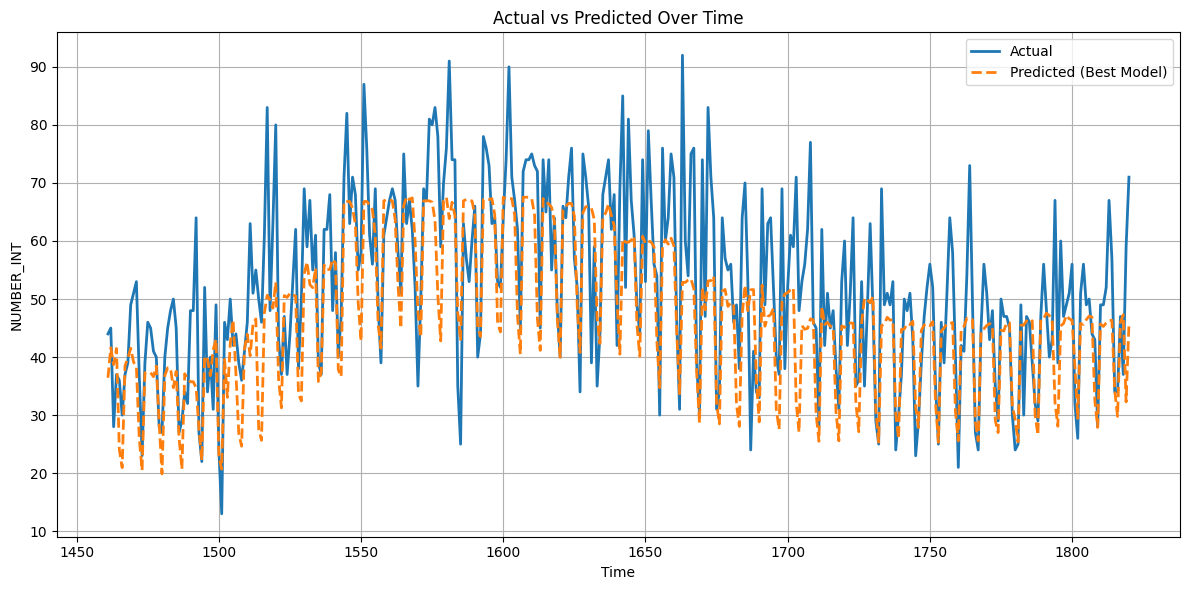

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(y_val.index, y_val.values, label='Actual', linewidth=2)
plt.plot(y_val.index, y_pred, label='Predicted (Best Model)', linewidth=2, linestyle='--')
plt.xlabel('Time')
plt.ylabel('NUMBER_INT')
plt.title(f'Actual vs Predicted Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

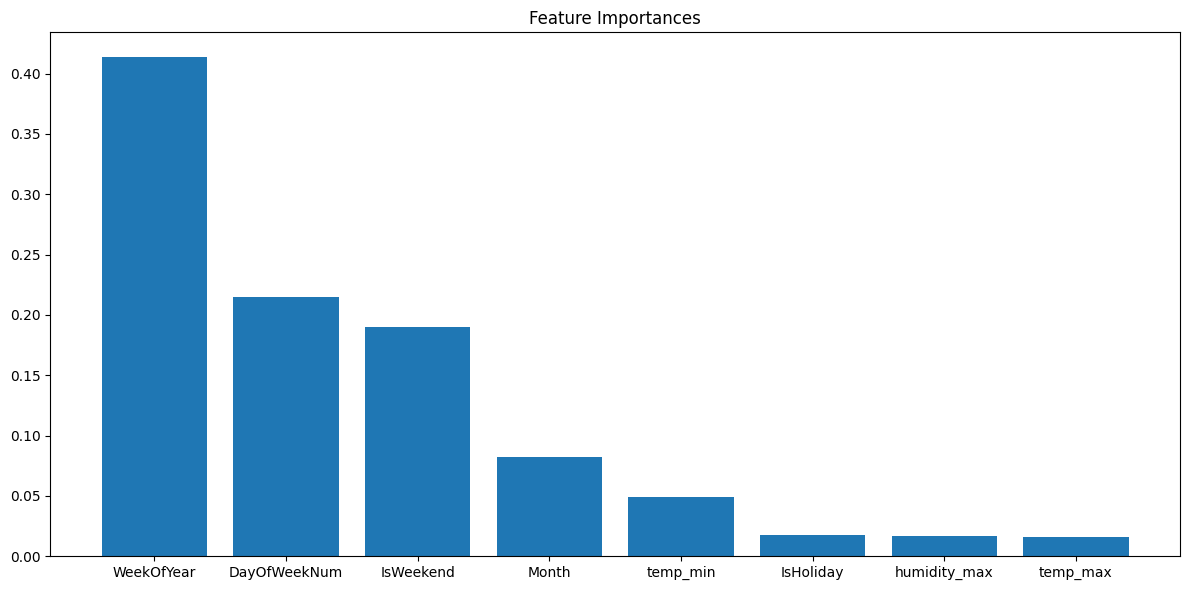

In [11]:
importances = best_rf_model_base.feature_importances_
features = X.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12,6))
plt.title('Feature Importances')
plt.bar(range(X.shape[1]), importances[indices])
plt.xticks(range(X.shape[1]), features[indices])
plt.tight_layout()
plt.show()

In [12]:
importances[indices]

array([0.41355776, 0.21510835, 0.19030288, 0.08203985, 0.04886889,
       0.01772122, 0.01689043, 0.01551062])

# Pointwise - CONFIVE

In [13]:
# Scaler

scaler = MinMaxScaler()
#scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_val_scaled = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns, index=X_val.index)

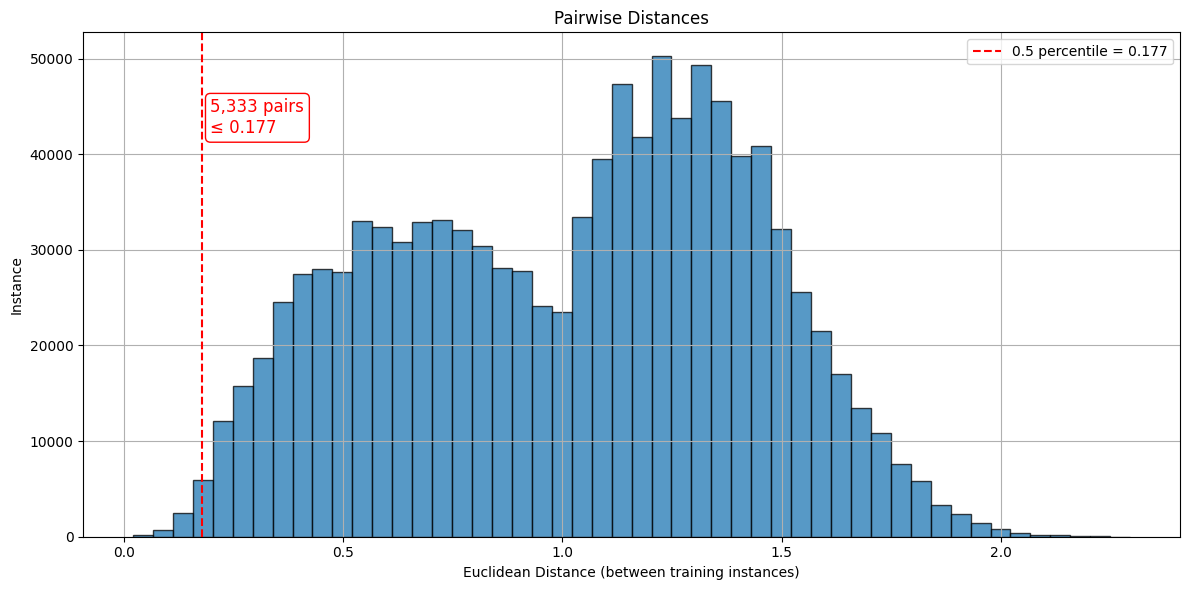

In [14]:
# Pairwise distances in training set
train_distance_matrix = euclidean_distances(X_train_scaled)
i_upper = np.triu_indices_from(train_distance_matrix, k=1)
pairwise_distances_train = train_distance_matrix[i_upper]

# TODO: select percentile (5th)
percentile_number = 0.5

selected_percentile = np.percentile(pairwise_distances_train, percentile_number)

count_below_percentile = np.sum(pairwise_distances_train <= selected_percentile)

plt.figure(figsize=(12, 6))
plt.hist(pairwise_distances_train, bins=50, edgecolor='black', alpha=0.75)
plt.axvline(selected_percentile, color='red', linestyle='--', label=f'{percentile_number} percentile = {selected_percentile:.3f}')
plt.text(selected_percentile + 0.02, plt.ylim()[1]*0.8,
         f'{count_below_percentile:,} pairs\n≤ {selected_percentile:.3f}',
         color='red', fontsize=12, bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.3'))

plt.xlabel("Euclidean Distance (between training instances)")
plt.ylabel("Instance")
plt.title("Pairwise Distances")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
within_threshold = (train_distance_matrix <= selected_percentile)

np.fill_diagonal(within_threshold, False)

# Count neighbors within threshold for each instance
neighbors_within_threshold = np.sum(within_threshold, axis=1)

k_max = int(np.mean(neighbors_within_threshold))
k_max

7

# Setup

In [16]:
final_min_cluster_uni = 7
final_min_cluster_dist = 0.177

In [17]:

class ConfiveScorer:
    """
    Local-variance confidence scorer (CONFIVE).

    Parameters
    ----------
    model: fitted regressor (trained on UN-scaled features)
    X_train_scaled: ndarray/DataFrame - scaled training features
    X_train_original: ndarray/DataFrame - un-scaled training features
    y_train: array-like - training targets
    k: int - neighbourhood size
    scale_scores: bool - if True (default) -> map variance to [0,1] and
                                 output confidence = 1 - scaled_variance.
                                 if False -> confidence = 1 - variance
                                                     (may be negative).
    """

    # -------------------------------------------------------------------------
    def __init__(
        self,
        model,
        X_train_scaled,
        X_train_original,
        y_train,
        k: int = 14,
        scale_scores: bool = True,
    ):
        self.k = k
        self.scale_scores = scale_scores
        self.model = model

        # store feature matrices
        self.Xts = np.asarray(X_train_scaled)
        self.Xto = (
            X_train_original.reset_index(drop=True)
            if isinstance(X_train_original, pd.DataFrame)
            else pd.DataFrame(
                np.asarray(X_train_original),
                columns=[f"f{i}" for i in range(np.asarray(X_train_original).shape[1])],
            )
        )

        # true targets
        self.y_train = np.asarray(y_train)

        # neighbour index (fit once on scaled space)
        self.nn = NearestNeighbors(n_neighbors=k).fit(self.Xts)

        # ---------------------------------------------------------------------
        # Pre-compute local variances for every training row (used only to
        # build the MinMaxScaler so we keep scoring in [0,1])
        # ---------------------------------------------------------------------

        # local variances for every training row  --------------------------
        _, idx_train = self.nn.kneighbors(self.Xts, n_neighbors=k)
        local_vars_train = np.var(self.y_train[idx_train], axis=1, ddof=1)



        # ------------------------------------------------------------------
        # Box‑plot
        plt.figure(figsize=(12, 6))
        plt.boxplot(local_vars_train, vert=False, showfliers=True, whis=1.5,
                    boxprops=dict(linewidth=1.2),
                    medianprops=dict(linewidth=1.2),
                    flierprops=dict(marker='o', markersize=4, markerfacecolor='red', alpha=0.5))
        plt.title("Distribution of local variances (k = {})".format(self.k))
        plt.xlabel("Unbiased variance of neighbour targets")
        plt.tight_layout()
        plt.show()

        # TODO IQR-based trimming *only* for the scaler fit
        q1, q3 = np.percentile(local_vars_train, [25, 75])
        iqr          = q3 - q1
        upper_fence  = q3 + 1.5 * iqr          #  upper fence
        #upper_fence  = q3 + 0.75 * iqr          #  upper fence
        self.upper_fence = upper_fence         # save for later

        trimmed = local_vars_train[local_vars_train <= upper_fence]

        # fit MinMaxScaler on the clipped distribution  --------------------
        if self.scale_scores:
            self.var_scaler = MinMaxScaler((0, 1)).fit(trimmed.reshape(-1, 1))



    # -------------------------------------------------------------------------
    def _confidence_from_variance(self, local_var: float) -> float:
        """
        Convert a local variance into a confidence score.
        """
        if self.scale_scores:
            var_scaled = self.var_scaler.transform([[local_var]])[0, 0] # 0 .. 1
            conf_raw = 1.0 - var_scaled
            return np.clip(conf_raw, 0.0, 1.0) # clip to [0,1]
        else:
            return 1.0 - local_var  # may be negative, no scaling

    # -------------------------------------------------------------------------
    def score(
        self,
        x_scaled,
        x_original=None,
        y_true_current=None,
        verbose: bool = False,
    ):
        """
        Compute CONFIVE confidence for a single validation instance.

        Parameters
        ----------
        x_scaled: 1-D array/Series or shape (1, n_features) - scaled row
        x_original: same row in original units (optional, for printing)
        y_true_current: true target for the row (optional, for printing)
        verbose: if True -> prints diagnostics & returns (score, details)

        Returns
        -------
        float  (or (score, details_dict) if verbose=True)
        """

        # --- ensure (1, n_features) ndarray ----------------------------------
        x_arr = np.asarray(x_scaled)
        if x_arr.ndim == 1:
            x_arr = x_arr.reshape(1, -1)

        # # --- k nearest neighbours (indices into training set) ----------------
        # _, idx = self.nn.kneighbors(x_arr, n_neighbors=self.k)
        # nbr_idx = idx[0]

        # # print(f"Neighbours indices: {nbr_idx}")

        # # --- CONFIVE statistic: local variance of neighbours' targets --------
        # local_var = np.var(self.y_train[nbr_idx], ddof=1)   # TODO:  (Eq.20  Neigbor mean, computed by numpy)
        # # unbiased variance (1/k) (Eq 19)

        ## SAME as  above:
        # --- k nearest neighbours ------------------------------------------------

        if verbose:
            print(f"Scoring instance: {x_arr}")

        _, idx = self.nn.kneighbors(x_arr, n_neighbors=self.k)
        nbr_idx = idx[0] # shape (k,)

        if verbose:
            print(f"Neighbours indices: {nbr_idx}")

        # neighbour target vector  (this corresponds to y1 .. y_k)
        y_k = self.y_train[nbr_idx] # shape (k,)

        if verbose:
            print(f"Neighbour targets: {y_k}")

        # Eq. 20  : neighbour mean
        bar_y = y_k.mean()

        if verbose:
            print(f"Neighbour mean: {bar_y:.4f}")

        # 
        local_var = ((y_k - bar_y) ** 2).sum() / (len(y_k) - 1)

        if verbose:
            print(f"y_k - bar_y: {y_k - bar_y}")




        # confidence score ρ(X*) = 1 - variance
        # --- confidence score -----------------------------------------------
        # TODO: use scaler ?
        conf_score = self._confidence_from_variance(local_var)

        if not verbose:
            return conf_score

        # ---------------------------------------------------------------------
        #   Verbose diagnostics block
        # ---------------------------------------------------------------------
        # Current instance features (original scale if supplied)
        current_orig = (
            np.asarray(x_original).reshape(1, -1)
            if x_original is not None else x_arr
        )
        current_df = pd.DataFrame(current_orig, columns=self.Xto.columns)

        # Model prediction for the current row (use original if given)
        y_pred_current = self.model.predict(current_orig)[0]

        # Neighbour information
        neigh_df   = self.Xto.iloc[nbr_idx].reset_index(drop=True)
        neigh_true = self.y_train[nbr_idx]

        print("\nCONFIVE diagnostics")
        print(f"Neighbourhood size k : {self.k}")
        print(f"Local variance       : {local_var:,.4f}")
        if self.scale_scores:
            var_scaled = self.var_scaler.transform([[local_var]])[0, 0]
            print(f"Scaled variance     : {var_scaled:.4f}")
        print(f"CONFIVE confidence   : {conf_score:.4f}\n")

        print("Current instance features:")
        print(current_df.to_string(index=False))

        print("\nCurrent instance target / prediction:")
        print(f"y_true : {y_true_current}" if y_true_current is not None else "y_true :  —")
        print(f"y_pred : {y_pred_current}\n")

        print("Neighbour feature rows:")
        print(neigh_df.to_string(index=False))

        print("\nNeighbour targets:")
        print(neigh_true)
        print("-" * 60)

        details = {
            "neigh_indices"     : nbr_idx,
            "current_features"  : current_df,
            "neighbour_features": neigh_df,
            "current_y_true"    : y_true_current,
            "current_y_pred"    : y_pred_current,
            "neigh_y_true"      : neigh_true,
            "local_variance"    : local_var,
            "confive_score"     : conf_score,
        }
        return conf_score, details

    # -------------------------------------------------------------------------
    #  Utility: global variance stats on the training set
    # -------------------------------------------------------------------------
    def print_variance_stats(self) -> None:
        """Print global variance and standard deviation of training targets."""
        var  = np.var(self.y_train, ddof=1)
        std  = np.sqrt(var)
        print(f"Training target variance : {var:,.4f}")
        print(f"Training target std.dev. : {std:,.4f}")


In [18]:
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

class ConfiveDensityScorer(ConfiveScorer):
    """
    CONFIVE * local-density.

    Extra parameter
    ---------------
    density_radius : float  – radius r (in the *scaled* space) used for the
                               density component  n_r / r  (capped at 1)
    """

    def __init__(
        self,
        *args,
        density_radius: float = 0.20,
        density_k: int = 14,         # the cap (final_min_cluster_uni)
        **kwargs,
    ):
        super().__init__(*args, **kwargs)
        self.density_radius = density_radius
        self.density_k = density_k    # store once

    # ------------------------------------------------------------------
    def _density_component(self, x_arr: np.ndarray) -> float:
        """density = min(n_r, k) / k,   k = self.density_k."""
        inds = self.nn.radius_neighbors(
            x_arr, radius=self.density_radius, return_distance=False
        )[0]
        n_r  = len(inds)
        return min(n_r, self.density_k) / self.density_k   # 0 .. 1

    # ------------------------------------------------------------------
    def score(
        self,
        x_scaled,
        x_original=None,
        y_true_current=None,
        verbose: bool = False,
    ):
        # --- base CONFIVE score (unchanged) ----------------------------
        confive_only = super().score(
            x_scaled = x_scaled,
            x_original = x_original,
            y_true_current = y_true_current,
            verbose = False,          # suppress base printing
        )

        # ensure shape (1, n_features) ndarray
        x_arr = np.asarray(x_scaled).reshape(1, -1)

        # --- density component ----------------------------------------
        density = self._density_component(x_arr)

        # --- combined reliability -------------------------------------
        print(f"CONFIVE score: {confive_only:.4f}")
        print(f"Density component: {density:.4f}")
        print(f"Density radius r: {self.density_radius}")
        reliability = confive_only * density

        if not verbose:
            return reliability

        # verbose: call parent once for diagnostics, then add density info
        _, details = super().score(
            x_scaled, x_original, y_true_current, verbose=True
        )
        print(f"Density radius r    : {self.density_radius}")
        print(f"Neighbours ≤ r      : {int(density * self.density_radius)}")
        print(f"Density component   : {density:.4f}")
        print(f"FINAL reliability   : {reliability:.4f}")
        details["density_component"] = density
        details["reliability"]       = reliability
        return reliability, details


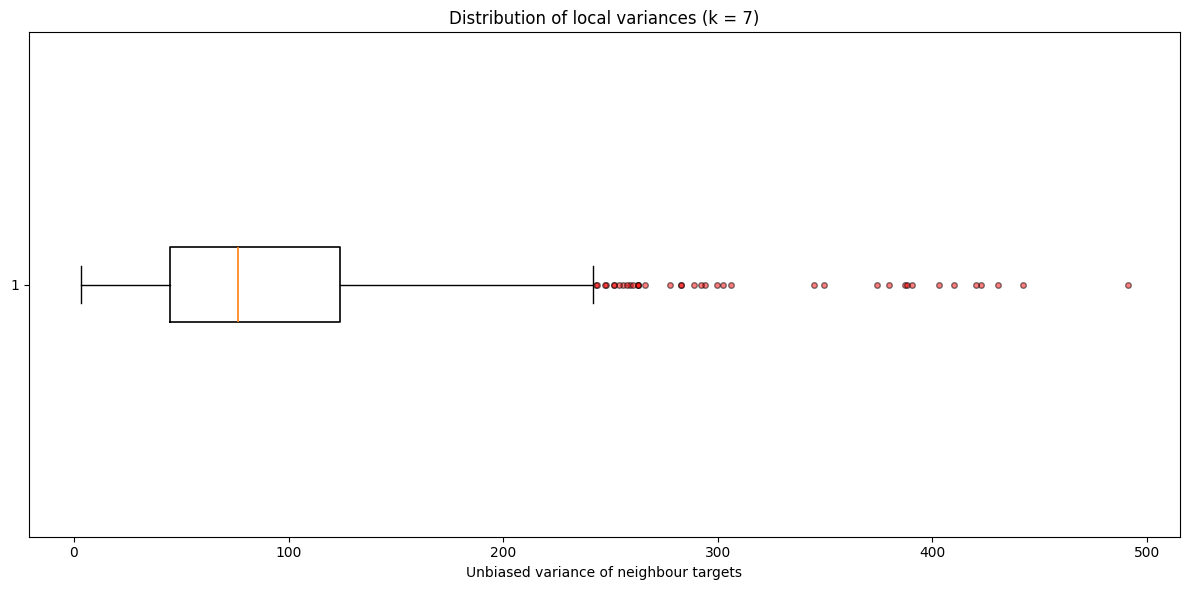

True Value: 28.0000
CONFIVE score: 0.7848
Density component: 0.3571
Density radius r: 0.177
Scoring instance: [[0.5        0.         0.         0.         0.         0.64824121
  0.77439024 0.88461538]]
Neighbours indices: [742 378 392 763  28 391 399]
Neighbour targets: [34 29 36 31 50 34 28]
Neighbour mean: 34.5714
y_k - bar_y: [-0.57142857 -5.57142857  1.42857143 -3.57142857 15.42857143 -0.57142857
 -6.57142857]

CONFIVE diagnostics
Neighbourhood size k : 7
Local variance       : 54.6190
Scaled variance     : 0.2152
CONFIVE confidence   : 0.7848

Current instance features:
 DayOfWeekNum  WeekOfYear  Month  IsWeekend  IsHoliday  temp_max  temp_min  humidity_max
          3.0         1.0    1.0        0.0        0.0      30.7      20.4          88.0

Current instance target / prediction:
y_true : 28
y_pred : 38.70871120420453

Neighbour feature rows:
 DayOfWeekNum  WeekOfYear  Month  IsWeekend  IsHoliday  temp_max  temp_min  humidity_max
            3           2      1          0   

c:\Users\Correia\Documents\Projects\hospital-adm-pw-rel\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [19]:
# confive = ConfiveScorer(
#     model = best_rf_model_base,
#     X_train_scaled = X_train_scaled,
#     X_train_original = X_train,     # un-scaled features
#     y_train = y_train,
#     k = final_min_cluster_uni,
#     scale_scores = True,        # Not confidence in [0,1]
# )

# # TODO: Sclae_scores = False to real confive


confive = ConfiveDensityScorer(
    model              = best_rf_model_base,
    X_train_scaled     = X_train_scaled,
    X_train_original   = X_train,
    y_train            = y_train,
    k                  = final_min_cluster_uni,
    scale_scores       = True,
    density_radius     = final_min_cluster_dist,
)



print (f"True Value: {y_val.iloc[2]:.4f}")


score, info = confive.score(
    x_scaled = X_val_scaled.iloc[2],
    x_original = X_val.iloc[2],      
    y_true_current = y_val.iloc[2],
    verbose = True,
)

In [20]:
# ▸ score the whole validation set (quietly)
scores = np.array([confive.score(row) for row in X_val_scaled.values])

CONFIVE score: 0.0000
Density component: 0.0000
Density radius r: 0.177
CONFIVE score: 0.8492
Density component: 0.4286
Density radius r: 0.177
CONFIVE score: 0.7848
Density component: 0.3571
Density radius r: 0.177
CONFIVE score: 0.8853
Density component: 0.4286
Density radius r: 0.177
CONFIVE score: 0.8859
Density component: 0.6429
Density radius r: 0.177
CONFIVE score: 0.9027
Density component: 0.3571
Density radius r: 0.177
CONFIVE score: 0.6061
Density component: 0.6429
Density radius r: 0.177
CONFIVE score: 0.8241
Density component: 0.9286
Density radius r: 0.177
CONFIVE score: 0.8147
Density component: 0.7143
Density radius r: 0.177
CONFIVE score: 0.7631
Density component: 0.7857
Density radius r: 0.177
CONFIVE score: 0.8311
Density component: 0.8571
Density radius r: 0.177
CONFIVE score: 0.8937
Density component: 0.7857
Density radius r: 0.177
CONFIVE score: 0.9930
Density component: 0.7857
Density radius r: 0.177
CONFIVE score: 0.7407
Density component: 0.7143
Density radius r

In [21]:
confive.print_variance_stats()

Training target variance : 240.6473
Training target std.dev. : 15.5128


In [22]:
scores

array([0.        , 0.36395236, 0.28028663, 0.37942333, 0.56951963,
       0.32238304, 0.38963759, 0.76522879, 0.58194199, 0.59954983,
       0.71234828, 0.70219101, 0.78022964, 0.52908998, 0.27238019,
       0.18133512, 0.39861246, 0.46521169, 0.23747792, 0.13493646,
       0.37472221, 0.39519346, 0.74824776, 0.18325831, 0.59362357,
       0.53495926, 0.48304747, 0.67633483, 0.12051969, 0.25750755,
       0.10980683, 0.06763918, 0.09553251, 0.0571685 , 0.58151462,
       0.67194712, 0.29068608, 0.12450852, 0.56550231, 0.78340646,
       0.61131688, 0.46196364, 0.25796342, 0.24750698, 0.22277623,
       0.80124224, 0.30565844, 0.67147701, 0.        , 0.84044675,
       0.34615933, 0.0993219 , 0.41107755, 0.2501567 , 0.4155365 ,
       0.0041028 , 0.30770984, 0.01331985, 0.21998404, 0.82409254,
       0.10769844, 0.86597527, 0.45267537, 0.46948544, 0.59578893,
       0.46344521, 0.29497407, 0.19773206, 0.13419568, 0.33087355,
       0.        , 0.55896347, 0.27129751, 0.56852242, 0.74172

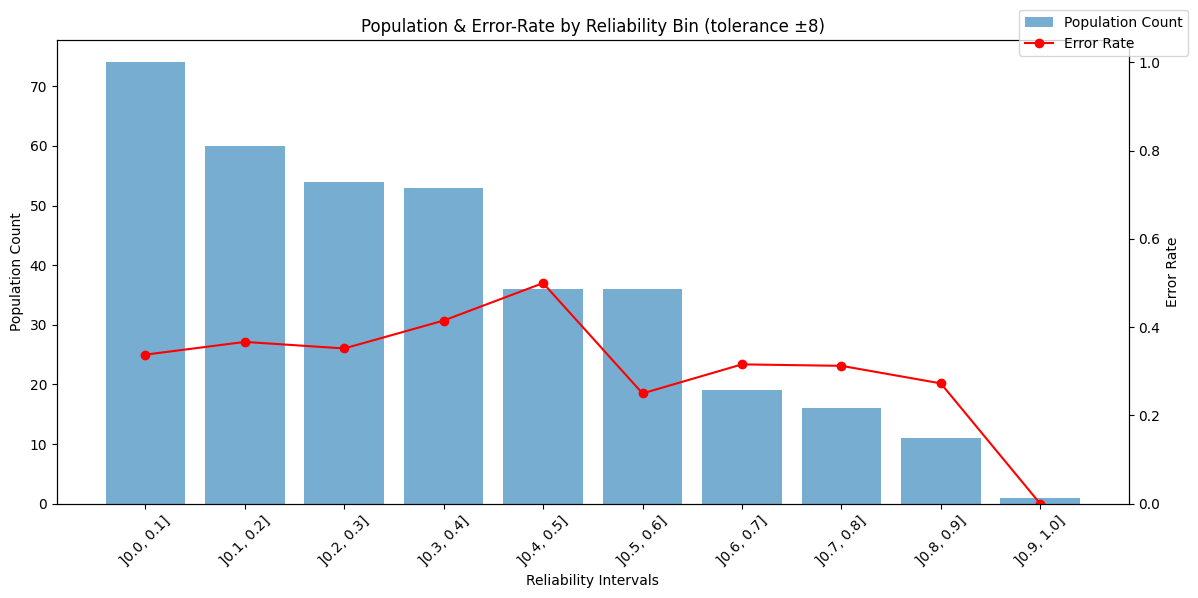

In [23]:
# ------------------------------------------------------------------
# CONFIVE reliability vs. error-rate plot
# ------------------------------------------------------------------

tolerance = 8 # TODO acceptable absolute-error band


# Assemble a DataFrame for analysis
df_plot = df_val.copy()
df_plot["y_true"]    = y_val.values
df_plot["y_pred"]    = y_pred
df_plot["abs_error"] = np.abs(df_plot["y_true"] - df_plot["y_pred"])
df_plot["correct"]   = df_plot["abs_error"] <= tolerance
df_plot["Reliability"] = scores

# Bin reliability into deciles
bins   = np.linspace(0, 1, 11)                       # 0.0, 0.1, …, 1.0
labels = [f"]{bins[i]:.1f}, {bins[i+1]:.1f}]" for i in range(len(bins)-1)]
df_plot["reliability_bin"] = pd.cut(
    df_plot["Reliability"], bins=bins,
    labels=labels, include_lowest=True
)

# Aggregate
grouped       = df_plot.groupby("reliability_bin", observed=True)
pop_count     = grouped.size()
error_rate    = 1 - grouped["correct"].sum() / pop_count

# Plot
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.bar(pop_count.index, pop_count.values,
        alpha=0.6, label="Population Count")
ax1.set_ylabel("Population Count")
ax1.set_xlabel("Reliability Intervals")
ax1.tick_params(axis='x', rotation=45)

ax2 = ax1.twinx()
ax2.plot(error_rate.index, error_rate.values,
         marker='o', color='red', label="Error Rate")
ax2.set_ylabel("Error Rate")
ax2.set_ylim(0, 1.05)

plt.title(f"Population & Error-Rate by Reliability Bin (tolerance ±{tolerance})")
fig.legend(loc="upper right", bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()


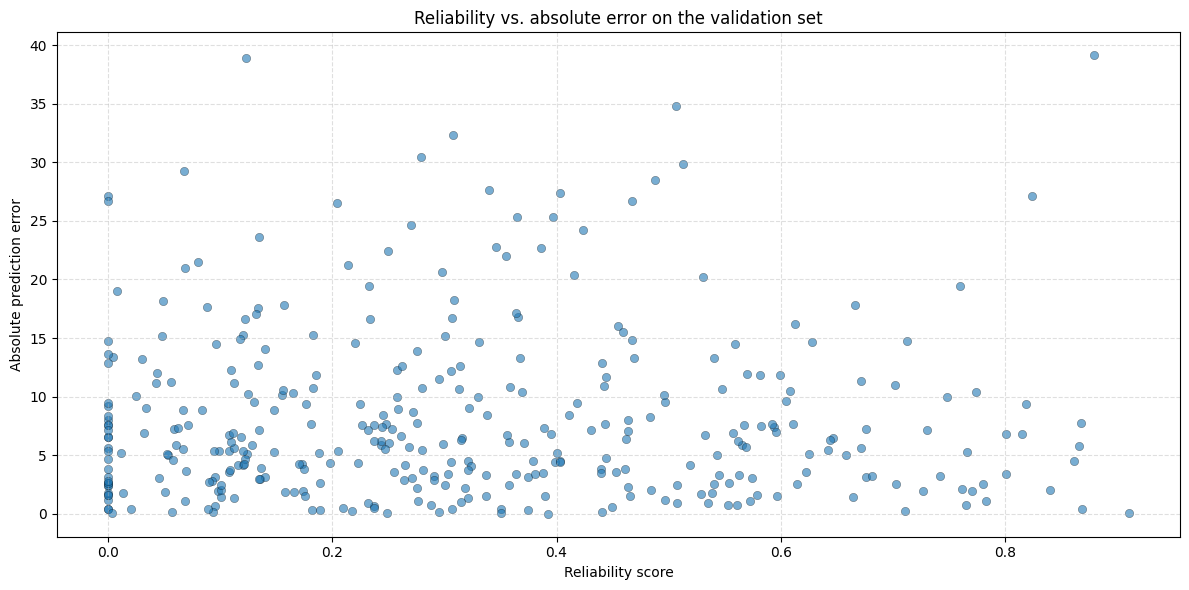

In [24]:
# ---------------------------------------------------------------
# Scatter: Reliability vs. absolute prediction error
# ---------------------------------------------------------------

errors = np.abs(y_val.values - y_pred)

df_re_err = pd.DataFrame({
    "Reliability": scores,
    "AbsError"   : errors,
})

plt.figure(figsize=(12, 6))
plt.scatter(df_re_err["Reliability"],
            df_re_err["AbsError"],
            alpha=0.6, edgecolor="k", linewidth=0.3)
plt.xlabel("Reliability score")
plt.ylabel("Absolute prediction error")
plt.title("Reliability vs. absolute error on the validation set")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


# Why ?

In [25]:
# ------------------------------------------------------------------
# Boolean mask & integer positions
# ------------------------------------------------------------------
high_mask   = scores >= 0.80          # same length/order as X_val / y_val
high_idx    = X_val.index[high_mask]  # pandas Index with the original labels
print("High-reliability indices:", list(high_idx))

# ------------------------------------------------------------------
# Build a one-stop table for inspection
# ------------------------------------------------------------------
df_hi = (
    X_val.loc[high_idx] # all original features
    .assign(y_true = y_val.loc[high_idx], # add target
            y_pred = y_pred[high_mask], # add prediction
            Reliab = scores[high_mask]) # add reliability
)

print("\n=== High-reliability rows ===")
print(df_hi.to_string()) # or df_hi.head() if too many rows


High-reliability indices: [1506, 1510, 1520, 1522, 1556, 1573, 1623, 1627, 1643, 1663, 1781, 1790]

=== High-reliability rows ===
      DayOfWeekNum  WeekOfYear  Month  IsWeekend  IsHoliday  temp_max  temp_min  humidity_max  y_true     y_pred    Reliab
1506             4           7      2          0          0      25.8      19.7          91.0      44  37.158203  0.801242
1510             1           8      2          0          0      29.0      19.6          93.0      46  43.924885  0.840447
1520             4           9      3          0          0      29.8      18.1          92.0      80  52.869790  0.824093
1522             6           9      3          1          0      29.0      19.9          88.0      37  31.245866  0.865975
1556             5          14      4          1          0      29.0      20.6          90.0      49  45.619349  0.800558
1573             1          17      4          0          0      29.5      19.6          84.0      67  66.921046  0.910451
1623     

In [26]:
# ---------------------------------------------------------------
# Fetch k = final_min_cluster_uni nearest neighbours
# ---------------------------------------------------------------
idx_query = 1663
k_neigh = final_min_cluster_uni

# query vectors
xq_scaled   = X_val_scaled.loc[idx_query].values.reshape(1, -1)
xq_original = X_val        .loc[idx_query]

# k-NN indices (training set rows)
nbr_idx = confive.nn.kneighbors(xq_scaled,
                                n_neighbors=k_neigh,
                                return_distance=False)[0]

# table of those neighbours
df_neigh = (
    X_train.loc[nbr_idx] # features
            .assign(y_true=y_train.loc[nbr_idx]) # + target
            .reset_index()
            .rename(columns={"index": "train_idx"})
)

# ---- display ---------------------------------------------------
print(f"\nQuery index {idx_query}")
print(xq_original.to_string())

print(f"\n{k_neigh} nearest neighbours (training rows):")
print(df_neigh.to_string(index=False))


# 1663             0          30      7          0          0      23.9      14.5          82.0      92  52.874487  0.878939


Query index 1663
DayOfWeekNum     0.0
WeekOfYear      30.0
Month            7.0
IsWeekend        0.0
IsHoliday        0.0
temp_max        23.9
temp_min        14.5
humidity_max    82.0

7 nearest neighbours (training rows):
 train_idx  DayOfWeekNum  WeekOfYear  Month  IsWeekend  IsHoliday  temp_max  temp_min  humidity_max  y_true
       200             0          30      7          0          0      24.8      15.3          81.0      51
       186             0          28      7          0          0      24.3      15.7          83.0      64
       928             0          29      7          0          0      24.4      13.3          80.0      58
      1299             0          30      7          0          0      24.9      14.6          77.0      55
       921             0          28      7          0          0      21.4      13.8          82.0      59
       536             0          25      6          0          0      24.7      14.1          83.0      59
       942         

In [27]:
# ---------------------------------------------------------------
# Fetch k = final_min_cluster_uni 
# ---------------------------------------------------------------
idx_query = 1520
k_neigh   = final_min_cluster_uni

# query vectors
xq_scaled   = X_val_scaled.loc[idx_query].values.reshape(1, -1)
xq_original = X_val.loc[idx_query]

# k-NN indices (training set rows)
nbr_idx = confive.nn.kneighbors(xq_scaled,
                                n_neighbors=k_neigh,
                                return_distance=False)[0]

# pretty table of those neighbours
df_neigh = (
    X_train.loc[nbr_idx] # features
            .assign(y_true=y_train.loc[nbr_idx]) # + target
            .reset_index()
            .rename(columns={"index": "train_idx"})
)

# ---- display ---------------------------------------------------
print(f"\nQuery index {idx_query}")
print(xq_original.to_string())

print(f"\n{k_neigh} nearest neighbours (training rows):")
print(df_neigh.to_string(index=False))

# 1520             4           9      3          0          0      29.8      18.1          92.0      80  52.869790  0.824093


Query index 1520
DayOfWeekNum     4.0
WeekOfYear       9.0
Month            3.0
IsWeekend        0.0
IsHoliday        0.0
temp_max        29.8
temp_min        18.1
humidity_max    92.0

7 nearest neighbours (training rows):
 train_idx  DayOfWeekNum  WeekOfYear  Month  IsWeekend  IsHoliday  temp_max  temp_min  humidity_max  y_true
        64             4          10      3          0          0      30.5      18.9          91.0      59
        71             4          11      3          0          0      30.1      19.0          93.0      54
      1170             4          11      3          0          0      31.0      18.6          93.0      60
      1177             4          12      3          0          0      28.4      18.1          92.0      43
       442             4          11      3          0          0      28.9      19.0          89.0      44
       421             4           8      2          0          0      29.6      18.3          94.0      51
        50         